# PERMANOVA test on images

**Dataset**: [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist)

**Model**: [ResNet18](https://arxiv.org/abs/1512.03385)

**Colab Runtime**: Nvidia T4

**Steps**:

1. Model is trained on the dataset deprived by the t-shirt class.

2. The distribution of the image embeddings of train and test set are compared with the ones of the t-shirt test set. The goal is to determine if null hypothesis is correctly rejected, meaning that we are able to determine that embeddings on an unseen image class do not come from the original population.

3. Train set is modified with an adversarial attack.

4. The embeddings distribution of the modified training test are compared with the original ones. Again, if null hypothesis is rejected means that PERMANOVA could be used to detect if model is making predictions on corrupted images.


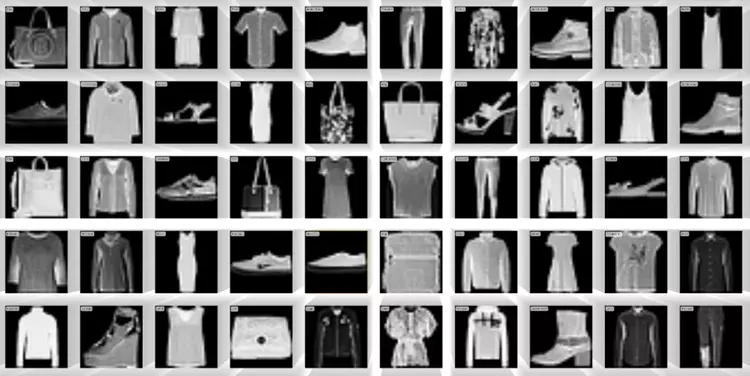

## Setup

In [1]:
!git clone https://github.com/AndreaZoccatelli/light_permanova
!pip install adversarial-robustness-toolbox

fatal: destination path 'light_permanova' already exists and is not an empty directory.


In [2]:
import sys

sys.path.append("/content/light_permanova/permanova/permanova_torch")
from lightpermanova import LightPERMANOVA

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.models import resnet18
from torchvision.transforms import ToTensor
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
from tqdm import tqdm
import time
import numpy as np

In [4]:
class ResNetFashionMnist(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = resnet18(num_classes=9)
        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )

    def forward(self, x):
        return self.model(x)

In [5]:
def predict(dataset, model, device):
    test_loader = data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    test_images, _ = next(iter(test_loader))

    test_images = test_images.to(device)

    with torch.no_grad():
        predictions = model(test_images)

    return predictions

## Dataset

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

test_data_tshirt = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:00<00:00, 32888532.66it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 9146278.73it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 10430722.81it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 25859014.36it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [7]:
no_tshirt_train = torch.where(training_data.targets != 0)
tshirt_train = torch.where(training_data.targets == 0)

training_data.targets = training_data.targets[no_tshirt_train[0]]
training_data.data = training_data.data[no_tshirt_train[0], :]

no_tshirt_test = torch.where(test_data.targets != 0)
tshirt_test = torch.where(test_data.targets == 0)

test_data.targets = test_data.targets[no_tshirt_test[0]]
test_data.data = test_data.data[no_tshirt_test[0], :]

training_data.targets -= 1
test_data.targets -= 1

In [8]:
test_data_tshirt.targets = test_data_tshirt.targets[tshirt_test[0]]
test_data_tshirt.data = test_data_tshirt.data[tshirt_test[0], :]

## Model Training + Save

In [9]:
model = ResNetFashionMnist().to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
n_epochs = 30
loader = data.DataLoader(training_data, shuffle=True, batch_size=128)

# Training loop
model.train()
for epoch in tqdm(range(n_epochs)):
    model.train()
    loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss}")

In [11]:
torch.save(model.state_dict(), "/content/model_state.pth")

## Load Trained Model

In [12]:
# Convert test data to TensorDataset
model = ResNetFashionMnist().to(device)
model.load_state_dict(torch.load("/content/model_state.pth", map_location=device))

<ipython-input-12-7514c2467b43>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/model_state.pth", map_location=device))


<All keys matched successfully>

In [13]:
predicted_classes = predict(test_data, model, device)
_, predicted_classes = torch.max(predicted_classes, 1)
acc = (
    torch.sum(predicted_classes.to("cpu") == test_data.targets)
    / test_data.targets.shape[0]
)
print(f"Accuracy Score: {round(acc.item(),5)}")

Accuracy Score: 0.93256


In [14]:
# Remove the output layer to obtain the embeddings
embedder = torch.nn.Sequential(*(list(model.model.children())[:-1]))
embedder = embedder.to(device)

In [15]:
# Embeddings of training dataset
train_emb = predict(training_data, embedder, device=device)
train_emb = train_emb.view(train_emb.shape[0], -1)

# Embeddings of test dataset
test_emb = predict(test_data, embedder, device=device)
test_emb = test_emb.view(test_emb.shape[0], -1)

# Embeddings of t-shirts test dataset
tshirt_emb = predict(test_data_tshirt, embedder, device=device)
tshirt_emb = tshirt_emb.view(tshirt_emb.shape[0], -1)

## Comparison with PERMANOVA

Comparison between train set and test set embeddings: the null hypothesis (samples are equal) is not rejected. PERMANOVA confirms that the images come from the same population.

In [16]:
permanova = LightPERMANOVA(train_emb, compress=False)
pvalue = permanova.run_simulation(test_emb, tot_permutations=1000)
print(f"p-value: {round(pvalue.item(),5)}")

  0%|          | 2/1000 [00:00<00:55, 17.84it/s]/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load

p-value: 0.999


Comparison between train/test set and t-shirts test set embeddings: the null hypothesis is rejected. The test confirms that embeddings produced by the model on an unseen category do not come from the original population.

In [17]:
permanova = LightPERMANOVA(test_emb, compress=False)
pvalue = permanova.run_simulation(tshirt_emb, tot_permutations=1000)
print(f"p-value: {round(pvalue.item(),5)}")

100%|██████████| 1000/1000 [03:34<00:00,  4.65it/s]


p-value: 0.03896


In [18]:
permanova = LightPERMANOVA(train_emb, compress=False)
pvalue = permanova.run_simulation(tshirt_emb, tot_permutations=1000)
print(f"p-value: {round(pvalue.item(),5)}")

/content/light_permanova/permanova/permanova_torch/lightpermanova.py:40: UserWarning: New sample is more than 10 times smaller than original sample, consider subsampling original sample for a more reliable test.
  warnings.warn(
100%|██████████| 1000/1000 [21:15<00:00,  1.28s/it]


p-value: 0.04595


## Adversarial Attack - Training

[Here](https://adversarial-robustness-toolbox.org/) the link to the adversarial robustness toolbox, a Linux Foundation project.

In [19]:
criterion = nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    input_shape=(1, 28, 28),
    nb_classes=9,
    device_type=device,
)

In [20]:
x_train = training_data.data.unsqueeze(1)
x_train = x_train.view(-1, 1, 28, 28)
x_train = np.array(x_train) / 255
x_train = np.float32(x_train)

In [21]:
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.05)

start = time.time()
x_train_adv = fgsm_attack.generate(x=x_train)
print("Time for attack (in seconds): {}".format(time.time() - start))

Time for attack (in seconds): 30.333730936050415


In [22]:
with open("/content/x_train_adv.npy", "wb") as file:
    np.save(file, x_train_adv)

## Adversarial Attack - Load adv. dataset

In [23]:
with open("/content/x_train_adv.npy", "rb") as file:
    x_train_adv = np.load(file)

In [24]:
predictions_train = classifier.predict(x_train)
acc = np.sum(
    np.argmax(predictions_train, axis=1) == np.array(training_data.targets)
) / len(training_data.targets)
print(f"Accuracy score on train set: {round(acc.item(),5)}")

Accuracy score on train set: 0.9957


In [25]:
predictions_adv = classifier.predict(x_train_adv)
acc = np.sum(
    np.argmax(predictions_adv, axis=1) == np.array(training_data.targets)
) / len(training_data.targets)
print(f"Accuracy score on adv. attacked train set: {round(acc.item(),5)}")

Accuracy score on adv. attacked train set: 0.32561


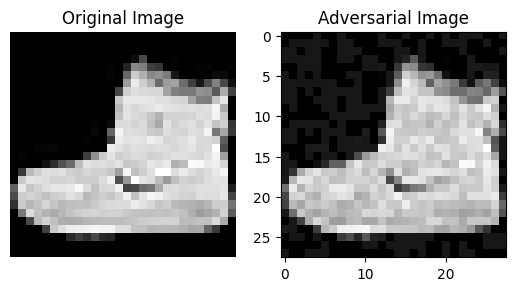

In [26]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].reshape(28, 28), cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(x_train_adv[0].reshape(28, 28), cmap="gray")
axs[1].set_title("Adversarial Image")
axs[0].axis("off")

plt.show()

## Comparison with PERMANOVA

p-value is less than 0.05: null is rejected. The test correctly detects that the corrupted images do not come from the original population.

In [27]:
with torch.no_grad():
    train_adv_emb = embedder(torch.from_numpy(x_train_adv).to(device))

train_adv_emb = train_adv_emb.view(train_adv_emb.shape[0], -1)

In [28]:
permanova = LightPERMANOVA(train_emb, compress=False)
pvalue = permanova.run_simulation(train_adv_emb, tot_permutations=1000)
print(f"p-value: {round(pvalue.item(),5)}")

100%|██████████| 1000/1000 [41:29<00:00,  2.49s/it]


p-value: 0.001
